In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from collections import OrderedDict, Counter
import powerlaw

# Reading MovieLens data

In [4]:
data_path = "../ML/"

#### Reading user information

In [15]:
users_df = pd.read_csv(data_path + "users.txt", header=None, sep='\t')
users_df.columns = ['userid', 'gender', 'age_range', 'occupation', 'zipcode']

female_userids = users_df.loc[users_df['gender']=='F', 'userid']
male_userids = users_df.loc[users_df['gender']=='M', 'userid']

In [16]:
print '# of all users {}'.format(users_df.shape[0])
print '# of all women {}'.format(len(female_userids))
print '# of all men   {}'.format(len(male_userids))

# of all users 6040
# of all women 1709
# of all men   4331


#### Reading rating data

In [17]:
rating_df = pd.read_csv(data_path + 'ratings.txt', sep='\t', header=None)
rating_df.columns = ['userid', 'itemid', 'rating', 'time']
print rating_df.head(2)

   userid  itemid  rating       time
0       1    1193       5  978300760
1       1     661       3  978302109


### Generating Python dictionaries where the key is userid and the value is user's profile size

#### Grouping rating data by userid and sorting by user profile sizes

In [25]:
# Grouping rating data by userid
rating_grbyuser = rating_df.groupby('userid')

# Seperate dictionaries for both genders were created for ease of plotting it later
userid_profSize = {}
female_profSize = {}
male_profSize = {}

for i, j in rating_grbyuser:
    
    # Profile size dictionary for all the users
    userid_profSize[i] = len(j)
    
    # Creating profile size dictionaries for females and males
    if i in female_userids:
        female_profSize[i] = len(j)
    else:
        male_profSize[i] = len(j)

# Sorting the dictionaries by profile size
userid_profSize_ord = OrderedDict(sorted(userid_profSize.items(), key=lambda x: x[1], reverse=False))
female_profSize_ord = OrderedDict(sorted(female_profSize.items(), key=lambda x: x[1], reverse=False))
male_profSize_ord = OrderedDict(sorted(male_profSize.items(), key=lambda x: x[1], reverse=False))

In [22]:
print 'Minimum profile size', min(userid_profSize_ord.values())
print 'Maximum profile size', max(userid_profSize_ord.values())
print
print 'Average profile size for females', np.average(female_profSize_ord.values())
print 'Average profile size for males  ', np.average(male_profSize_ord.values())

Minimum profile size 20
Maximum profile size 2314

Average profile size for females 164.359484778
Average profile size for males   166.085641736


# User profile size distribution

####  Profile size distribution for females

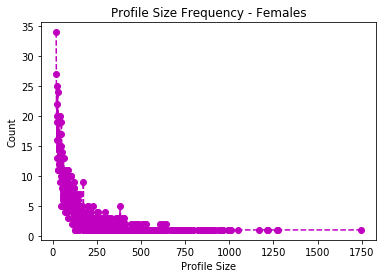

In [31]:
# Counter function creates a dictionary where the key is profile size and the value is its count.
female_profilesize_counter = Counter(female_profSize_ord.values())
plt.plot(female_profilesize_counter.keys(), female_profilesize_counter.values(), linestyle='--', marker='o', color='m')

plt.title("Profile Size Frequency - Females")
plt.xlabel("Profile Size")
plt.ylabel("Count")

####  Profile size distribution for males

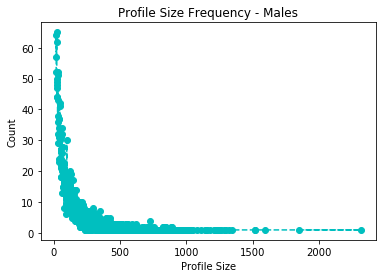

In [28]:
male_profilesize_counter = Counter(male_profSize_ord.values())
plt.plot(male_profilesize_counter.keys(), male_profilesize_counter.values(), linestyle='--', marker='o', color='c')

plt.title("Profile Size Frequency - Males")
plt.xlabel("Profile Size")
plt.ylabel("Count")

####  Profile size distribution over all users

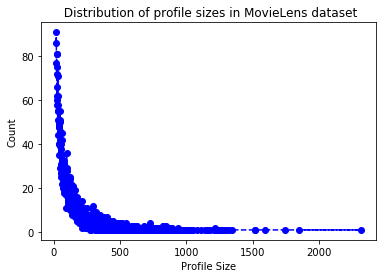

In [29]:
profilesize_counter = Counter(userid_profSize_ord.values())
plt.plot(profilesize_counter.keys(), profilesize_counter.values(), linestyle='--', marker='o', color='b')

plt.xlabel("Profile Size")
plt.ylabel("Count")
plt.title(" Distribution of profile sizes in MovieLens dataset")

### Profile size distribution by Gender - Combined

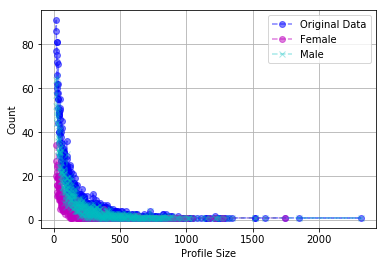

In [32]:
plt.plot(profilesize_counter.keys(), profilesize_counter.values(), linestyle='--', marker='o', color='b', alpha=0.5)
plt.plot(female_profilesize_counter.keys(), female_profilesize_counter.values(), linestyle='--', marker='o', color='m', alpha=0.5)
plt.plot(male_profilesize_counter.keys(), male_profilesize_counter.values(), linestyle='--', marker='x', color='c', alpha=0.35)

plt.xlabel("Profile Size")
plt.ylabel("Count")
plt.legend(['Original Data', 'Female', 'Male'])
plt.grid(True)

## Profile length distribution by gender

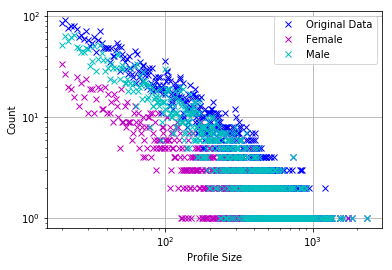

In [34]:
plt.loglog(profilesize_counter.keys(), profilesize_counter.values(), 'xb')
plt.loglog(female_profilesize_counter.keys(), female_profilesize_counter.values(), 'xm')
plt.loglog(male_profilesize_counter.keys(), male_profilesize_counter.values(), 'xc')

plt.xlabel('Profile Size')
plt.ylabel('Count')
plt.legend(['Original Data', 'Female', 'Male'])
plt.grid(True)

## Estimating alpha of the power law distribution

### Profile size distribution of users follows a power-law distribution, let's see to what extent it fits a power-law distribution and what is the exponent of the distribution.

ALPHA is : 1.50801741489 

1.0
118.727088741 3.75883003808e-05


Calculating best minimal value for power law fit


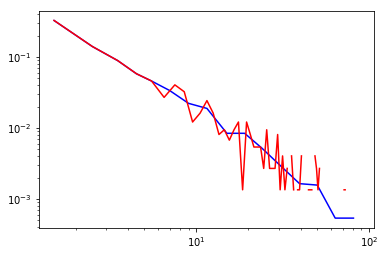

In [133]:
x = profilesize_counter.values() # the data is a list of the count of different profile sizes ordered from 20 ro 2314.

fit = powerlaw.Fit(x, discrete=True) 
print 'ALPHA is :', fit.alpha, '\n'
print fit.xmin

# if R positive it's similar to the first distribution, if negative to the second distribution.
R, p = fit.distribution_compare('power_law', 'exponential')
print R, p

figPDF = powerlaw.plot_pdf(x, color='b')
powerlaw.plot_pdf(x, linear_bins=True, color='r', ax=figPDF)

# Main functions of FLAG algorithm

In [38]:
# Expected number of group B users under f
def Exp_groupB_size(alpha):
    SUM_EfB = 0.0
    for profsize in profilesize_counter.keys():
        fBi = 1.0 / pow(profsize, alpha)  # Probability of membership in group B
        usercount = profilesize_counter[profsize]  # The number of users with this profile size
        SUM_EfB += (usercount * fBi) # Sum over all the profile sizes 
    return SUM_EfB


# Group B membership probability
def Flag_Bi(alpha, beta, profsize):
    return (beta * users_df.shape[0] * 1.0) / (pow(profsize, alpha) * Exp_groupB_size(alpha))


def avg_profsize(profsize_freq_dict):
    if len(profsize_freq_dict) != 0:
        summ = 0
        for key, value in profsize_freq_dict.items():
            summ += key * value * 1.0
        return summ / len(profsize_freq_dict)
    else:
        return 0

# FLAG - Frequency Linked Attribute Generation

### Parameter Alpha is controlling the skew of the power-law distribution.
### Parameter Beta is for controlling the relative sizes of two groups.
### isTuning parameter will be set to 1 if we are tuning the algorithm to find the best parameters. If it's set to 0, we have the best parameters so we plot the distributions.

In [125]:
def synthAttrGen(alpha, beta, isTuning):

    user_membership = {}
    groupA = {}
    groupB = {}

    # Iterating through user ids
    for userid in userid_profSize_ord.keys():

        # Go through users and calculate the probability of being in group B based on their profile size
        user_profile_size = userid_profSize_ord[userid] # user profile size
        p = Flag_Bi(alpha, beta, user_profile_size) # probability of being in group B based on profile size

        # Run a Bernouli trial with p which is the probability of success (being in group B). 
        # On success, assign user u to group B otherwise to group A.
        result = sum(np.random.binomial(1.0, p, size=5)) / 5.0  # trials, p of success, number of experiments 

        # on success add it to group B otherwise A
        if result >= 0.5:
            # B
            groupB[userid] = userid_profSize_ord[userid]
        else:
            # A
            groupA[userid] = userid_profSize_ord[userid]
    
    # key : profile size, value : count => for ease of plotting
    A_profilesize_counter = Counter(groupA.values())
    B_profilesize_counter = Counter(groupB.values())
    
    # If we're done tuning the algorithm to find the best parameters,
    #  plot the figures to choose the set of parameters that is more similar to the original distribution.
    if isTuning != 1:
        
        # Calculating the average profile size length for both groups
        print 'Average profile length for group A', avg_profsize(A_profilesize_counter)
        print 'Average profile length for group B', avg_profsize(B_profilesize_counter)
        
        # Plot the profile size distributions
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(profilesize_counter.keys(), profilesize_counter.values(), linestyle='--', marker='o', color='b', alpha=0.5)
        plt.plot(B_profilesize_counter.keys(), B_profilesize_counter.values(), linestyle='--', marker='o', color='m', alpha=0.5)
        plt.plot(A_profilesize_counter.keys(), A_profilesize_counter.values(), linestyle='--', marker='o', color='c', alpha=0.5)

        plt.legend(['Original Data', 'Group B', 'Group A'])
        plt.title('Profile Size Distribution - Synthetic Data')
        plt.xlabel('Profile Size')
        plt.ylabel('Count')
        plt.grid(True) 

        
        # profile length distribution for synthetic data - loglog scale
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 2)
        plt.loglog(profilesize_counter.keys(), profilesize_counter.values(), 'xb')
        plt.loglog(B_profilesize_counter.keys(), B_profilesize_counter.values(), 'xm')
        plt.loglog(A_profilesize_counter.keys(), A_profilesize_counter.values(), 'xc',alpha=0.5)
        plt.xlabel('Profile Size')
        plt.ylabel('Count')
        plt.legend(['Original Data', 'GroupB', 'GroupA'])
        plt.grid(True)
        
        plt.show()
        return
    
    return len(groupA), len(groupB)

# Parameter Tuning

### Finding legal values for alpha and beta where the distribution is as similar to the original distribution as possible. Picking the alpha, beta pairs where the fractions of users in group A and B is similar to the fraction of males and females in the original dataset.

In [132]:
# The original data has 1709.0 female to 4331 male, the fraction is 0.3945
FemaleToMaleRatio = 1709.0/4331

print 'Best parameters are'
print
print '{}\t{}\t{}\t{}'.format('Alpha', 'Beta', 'B to A Ratio', 'F to M Ratio')

# define alpha range, it can range from 0 to positive infinity
for alpha in np.linspace(0.01, 2, 10):

    # Computing maximum legal value for beta according to the paper
    beta_legal_max = Exp_groupB_size(alpha) / (users_df.shape[0] * (pow(1, -alpha)))
    
    # Go through the legal values of beta to find the best parameter(s)
    for beta in np.linspace(0, beta_legal_max, 7):
        groupALen, groupBLen = synthAttrGen(alpha, beta, isTuning=1) 
        try:
            BtoAratio = groupBLen*1.0/groupALen # Calculating the fraction of group B (minority group) to group A
            
            # if it is similar to the ratio of females to males in the dataset, we select the parameters
            if FemaleToMaleRatio-0.15 <= BtoAratio <= FemaleToMaleRatio+0.15:
                print '{0:5.2f}\t{1:4.2f}\t{2:12.2f}\t{3:12.2f}'.format(alpha, beta, BtoAratio, FemaleToMaleRatio)
                
        except ZeroDivisionError as error:
            'Skip - group A\'s size is zero.'
            pass

Best parameters are

Alpha	Beta	B to A Ratio	F to M Ratio
 0.23	0.35	        0.36	        0.39


#### We can have different alpha and beta parameters.  
#### We choose the alpha beta parameter pair where the Group B to Group A ratio is closer to Female to Male ratio.

## Plot the figures based on the best parameters.

Average profile length for group A 1184.70401107
Average profile length for group B 480.494983278


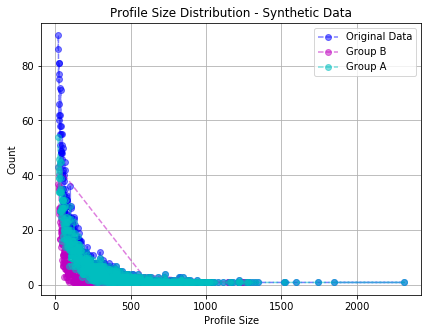

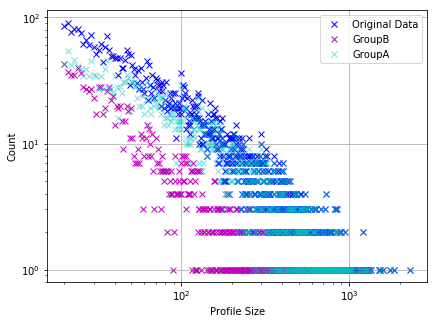

In [126]:
synthAttrGen(alpha=0.23, beta=0.35, isTuning=0)